### Delete this later
NOTE TBD: means notes for us, to be deleted

### Sections to do
1. ~~Title + authors (your names)~~
2. Introduction to the problem/task and dataset
Link to the Kaggle dataset or other sources
3. Description of the dataset
Describe your data and show what kind of initial features you are dealing with
Describe what each instance of your dataset represents
4. List of requirements (Python libraries, datasets/files)
5. Simple exploratory data analysis
Point out anomalies/outliers in the data
Show graphs to quickly digest data distributions and possible patterns
6. Data preprocessing/cleaning
Explain why the data was preprocessed that way
If you removed data, explain why removing the data was necessary
7. Feature engineering
Explain (even if briefly) what these features are, and why they may help
8. Model training
Explain why you chose the algorithms you are training with
9. Feature selection + Hyperparameter tuning
You may use grid/random search for hyperparameter tuning
10. Model selection
Present a summary of your best model configuration
You can use this website to make tables easier to manage
11. Insights and conclusions
Explain what insights you have learned from the models (why they failed/succeeded)
Summarize your conclusions on which model performed the best and why
12. Ask for the user’s input and show prediction
Please refer to the Naive Bayes notebook, where you can test if a phrase is ham/spam
13. References
You are encouraged to look at existing solutions online and learn from them (please cite)

# STINTSY Machine Project
#### S14 Group X
- Aldecoa, Renzel Raphael
- Bautista, Carlo Gabriel
- Canicon, Jan Ambro

# CS:GO Cheating Dataset
The [dataset](https://www.kaggle.com/datasets/emstatsl/csgo-cheating-dataset) used features gameplay input from players, segregated into non-cheating (henceforth "legit") and cheating players. The main task with the dataset is to categorize players as "cheating" based on their game input. There are a total of `12 000` samples in the dataset, divided into two groups of `10 000` legit players and `2 000` cheating players.

The dataset has a shape of `[X, 30, 192, 5]`, with the dimensions as follows:
- `X` — `player` the number of players in the subset (`10 000` legit, `2 000` cheater)
- `30` — `engagement` specifies the encounter with other players
- `192` — `game_tick` in-game time increment holding player vectors and other game info
- `5` — `player_input` input sent by players such as change in aim yaw and pitch

The player input dimension of the dataset can be further explained as follows:
- `AttackerDeltaYaw`, `AttackerDeltaPitch`
    - Change in the direction of the attacking player’s aim
- `CrosshairToVictimYaw`, `CrosshairToVictimPitch`
    - Distance remaining between the attacker’s crosshair and target’s hitbox
- `Firing`
    - Whether the attacker is firing or not

Additionally note that yaw refers to the left-right movement axis, and pitch refers to up-down movement axis. These are scaled in the 360-degree measurement, with a range of `[-180, 180]`.

TODO: Explain features more

# Dependencies
- [Dataset](https://www.kaggle.com/datasets/emstatsl/csgo-cheating-dataset) (Both legit.npy and cheaters.npy)
- numpy
- pandas
- matplotlib

# Library Imports and Notebook Initialization

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.model_selection import train_test_split
# Fix floats to display decimals instead of exponential notation
pd.options.display.float_format = '{0:.4f}'.format

# Loading the dataset

In [2]:
legit_data = np.load('legit.npy')
cheaters_data = np.load('cheaters.npy')

print('Legit:', legit_data.shape)
print('Cheaters:', cheaters_data.shape)

Legit: (10000, 30, 192, 5)
Cheaters: (2000, 30, 192, 5)


# Preprocessing
TODO:
- Possibly balance the ratio of legit and cheaters?
- Delta of CrosshairToTarget?
    - Theory: Consistent means aimlock

The dataset is stored in a format of `[player, engagement, game_tick, player_input]`, and we can further flatten it by combining `engagement` and `game_tick` as `tick`, because these are all []. However, we cannot further flatten `player_input` with `tick` because these are the features, and flattening would scramble them. Thus, we will be training and testing the model with a 3-dimensional dataset later on.

After flattening the dimensions, we can also combine the two datasets.

In [3]:
# Combines the dimensions engagement and game_tick
legit_data = legit_data.reshape(10000, 5760, 5)
cheaters_data = cheaters_data.reshape(2000, 5760, 5)

# Combine legit and cheater datasets
X_players = np.vstack([legit_data, cheaters_data])
print('Training data shape:', X_players.shape)

Training data shape: (12000, 5760, 5)


Since we append the cheaters to the end of the list of legit players, we can easily create a list that contains their classes by using the length of each list. The classes will be:
- `0` — `Legit` player
- `1` — `Cheating` player

In [4]:
# Create truth values for combined list
y_players = np.append(
        np.zeros(legit_data.shape[0], dtype=int),
        np.full(cheaters_data.shape[0], 1, dtype=int)
)
print('Ground truth values shape:', y_players.shape)

Ground truth values shape: (12000,)


In [5]:
# Get abs of players for raw distance to target?
# X_players = np.abs(X_players)

# Exploratory Data Analysis

In [21]:
# https://stackoverflow.com/questions/38901145/create-a-dataframe-with-a-multiindex
# Create DataFrame for legit players
cols = ['AttackerDeltaYaw', 'AttackerDeltaPitch', 'CrosshairToVictimYaw', 'CrosshairToVictimPitch', 'Firing']
playernums = [i for i in range(legit_data.shape[0])]
ticknums = [i for i in range(legit_data.shape[1])]
index = pd.MultiIndex.from_product([playernums, ticknums],
                                 names=['Player', 'Game Tick'])
newshape = legit_data.shape[0] * legit_data.shape[1]

legit_df = pd.DataFrame(legit_data.reshape(newshape, 5), index, cols)

# Create DataFrame for cheaters
cols = ['AttackerDeltaYaw', 'AttackerDeltaPitch', 'CrosshairToVictimYaw', 'CrosshairToVictimPitch', 'Firing']
playernums = [i for i in range(cheaters_data.shape[0])]
ticknums = [i for i in range(cheaters_data.shape[1])]
index = pd.MultiIndex.from_product([playernums, ticknums],
                                 names=['Player', 'Game Tick'])
newshape = cheaters_data.shape[0] * cheaters_data.shape[1]

cheaters_df = pd.DataFrame(cheaters_data.reshape(newshape, 5), index, cols)

In [22]:
legit_df = legit_df.abs()
cheaters_df = cheaters_df.abs()

In [23]:
legit_df.describe()

,AttackerDeltaYaw,AttackerDeltaPitch,CrosshairToVictimYaw,CrosshairToVictimPitch,Firing
count,57600000.0000,57600000.0000,57600000.0000,57600000.0000,57600000.0000
mean,0.9144,0.2001,20.1014,3.7624,0.0521
std,3.2281,0.5578,30.3326,6.2394,0.2175
min,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,2.1560,0.8570,0.0000
50%,0.1320,0.0490,9.8550,2.4800,0.0000
75%,0.6540,0.2250,31.2710,6.0000,0.0000
max,180.0000,88.9950,180.0000,154.1330,1.0000


In [24]:
cheaters_df.describe()

,AttackerDeltaYaw,AttackerDeltaPitch,CrosshairToVictimYaw,CrosshairToVictimPitch,Firing
count,11520000.0000,11520000.0000,11520000.0000,11520000.0000,11520000.0000
mean,1.0210,0.2196,22.8156,4.5182,0.0512
std,3.0765,0.6676,31.3499,6.3601,0.2158
min,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,2.1430,0.9360,0.0000
50%,0.1320,0.0490,9.7970,2.5730,0.0000
75%,0.6870,0.2200,31.0930,6.0090,0.0000
max,179.6980,98.6020,180.0000,119.4610,1.0000


5952 6144


C:\Users\carlo\AppData\Local\Temp/ipykernel_24812/2003225572.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  legit.set_index((legit.index.get_level_values('Game Tick') / engagement - 192), 'Game Tick', inplace=True)
C:\Users\carlo\AppData\Local\Temp/ipykernel_24812/2003225572.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  cheater.set_index((cheater.index.get_level_values('Game Tick') / engagement - 192), 'Game Tick', inplace=True)


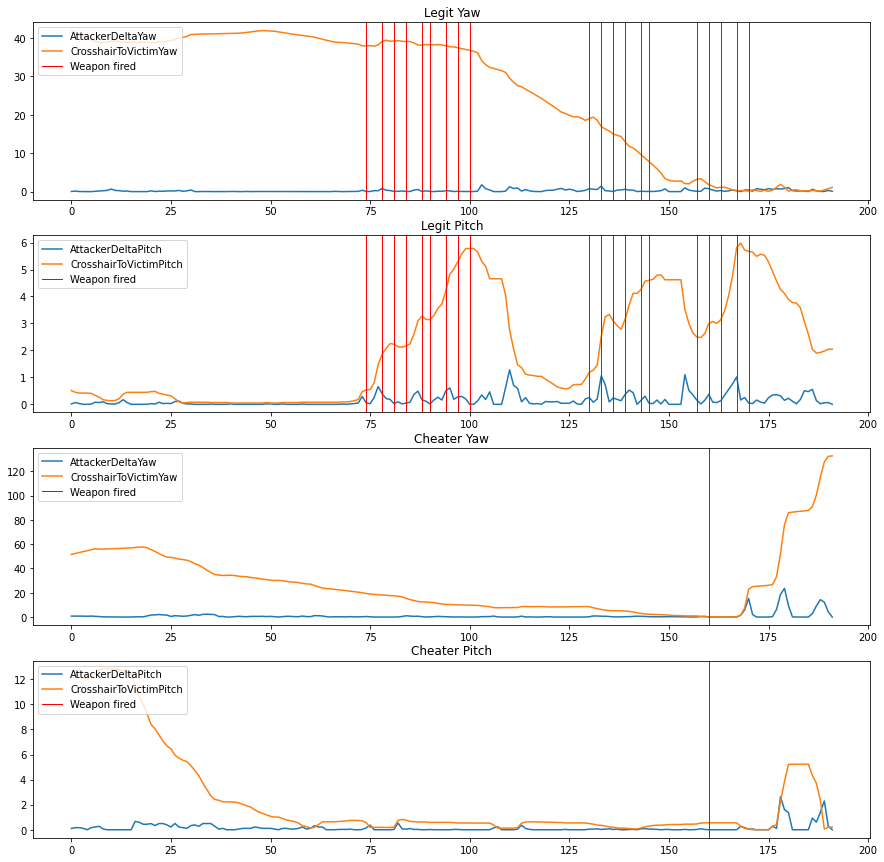

In [25]:
#Choose which player (0 - 1999)
player = 1

# Choose which engagement (0 - 29)
engagement = 1

# Set index for retrieval
start = (player * 5760) + (engagement * 192)
end = (player * 5760) + ((engagement + 1) * 192)
print(start, end)

# Gets specific player engagement
legit = legit_df.iloc[start:end]
cheater = cheaters_df.iloc[start:end]

# Converts timestamp to align with actual time instead of dataset
if(start > 0):
    legit.set_index((legit.index.get_level_values('Game Tick') / engagement - 192), 'Game Tick', inplace=True) 
    cheater.set_index((cheater.index.get_level_values('Game Tick') / engagement - 192), 'Game Tick', inplace=True) 

# Gets timestamps of when players fired
legit_firing = legit[legit['Firing'] == 1]
cheater_firing = cheater[cheater['Firing'] == 1]

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(411)
ax1.set_title('Legit Yaw')
plt.plot(legit['AttackerDeltaYaw'], label='AttackerDeltaYaw')
plt.plot(legit['CrosshairToVictimYaw'], label='CrosshairToVictimYaw')
[plt.axvline(x, linewidth=1, color='r') for x in legit_firing.index.get_level_values('Game Tick')]
ax1.lines[-1].set_label('Weapon fired')
plt.legend(loc='upper left')

ax2 = fig.add_subplot(412)
ax2.set_title('Legit Pitch')
plt.plot(legit['AttackerDeltaPitch'], label='AttackerDeltaPitch')
plt.plot(legit['CrosshairToVictimPitch'], label='CrosshairToVictimPitch')
[plt.axvline(x, linewidth=1, color='r') for x in legit_firing.index.get_level_values('Game Tick')]
ax2.lines[-1].set_label('Weapon fired')
plt.legend(loc='upper left')

ax3 = fig.add_subplot(413)
ax3.set_title('Cheater Yaw')
plt.plot(cheater['AttackerDeltaYaw'], label='AttackerDeltaYaw')
plt.plot(cheater['CrosshairToVictimYaw'], label='CrosshairToVictimYaw')
[plt.axvline(x, linewidth=1, color='r') for x in cheater_firing.index.get_level_values('Game Tick')]
ax3.lines[-1].set_label('Weapon fired')
plt.legend(loc='upper left')

ax4 = fig.add_subplot(414)
ax4.set_title('Cheater Pitch')
plt.plot(cheater['AttackerDeltaPitch'], label='AttackerDeltaPitch')
plt.plot(cheater['CrosshairToVictimPitch'], label='CrosshairToVictimPitch')
[plt.axvline(x, linewidth=1, color='r') for x in cheater_firing.index.get_level_values('Game Tick')]
ax4.lines[-1].set_label('Weapon fired')
plt.legend(loc='upper left')

Theories
- If yaw/pitch move by X, cheater crosshair should move X closer to target
- Cheaters have low CrosshairToVictimPitch (aim is locked on, or always very close)

In order to add more randomness for the splitting of the train and test sets later on, we shuffle this combined list. To do so while keeping the correspondence of the rows from both lists, we shuffle the indices instead and assign them to both lists.

In [26]:
# https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order
# Generate shuffled indices
indices = np.arange(X_players.shape[0])
np.random.shuffle(indices)

# Assign shuffled indices to both lists
X_players = X_players[indices]
y_players = y_players[indices]

## TEST

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.python.client import device_lib
import keras_tuner

In [7]:
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
X_players = X_players.reshape(12000, 28800)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16178210568089095038
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5738397696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6218075578926640630
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6



In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_players,y_players,random_state= 0,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state= 0,test_size=0.2)

In [46]:
import numpy as np
import tensorflow as tf



batch=32

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
X_train.shape    
num_epochs = 40
model.fit(X_train, y_train, epochs=num_epochs,batch_size=batch,validation_split=0.2)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [39]:
X_train.shape   

(7680, 28800)

In [40]:
y_train.shape

(7680,)

In [41]:
X_val.shape

(1920, 28800)

In [42]:
y_val.shape

(1920,)

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (32, 5)                   144005    
                                                                 
 dense_18 (Dense)            (32, 32)                  192       
                                                                 
 dense_19 (Dense)            (32, 32)                  1056      
                                                                 
 dense_20 (Dense)            (32, 1)                   33        
                                                                 
Total params: 145,286
Trainable params: 145,286
Non-trainable params: 0
_________________________________________________________________


In [44]:
results = model.evaluate(X_test, y_test, batch_size=batch)

75/75 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.8217


In [45]:
print(results)

[0.48426294326782227, 0.8216666579246521]


In [9]:
predictions = model.predict(X_test)

75/75 [==============================] - 1s 9ms/step


In [158]:
print(predictions)

[[6.5011909e-04]
 [9.2474587e-04]
 [8.6611277e-01]
 ...
 [5.2007270e-04]
 [3.1917796e-07]
 [1.0570274e-10]]


In [96]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=960, step=32),
                activation=hp.Choice("activation", ["relu", "tanh","elu","selu"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [97]:
build_model(keras_tuner.HyperParameters())

In [98]:

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    overwrite=True,
    directory="res"
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 960, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [99]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 11s]
val_accuracy: 0.841796875

Best val_accuracy So Far: 0.8430989384651184
Total elapsed time: 00h 03m 21s
INFO:tensorflow:Oracle triggered exit


In [101]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(X_train.shape))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (7680, 28800)             0         
                                                                 
 dense (Dense)               (7680, 192)               5529792   
                                                                 
 dense_1 (Dense)             (7680, 736)               142048    
                                                                 
 dense_2 (Dense)             (7680, 32)                23584     
                                                                 
 dense_3 (Dense)             (7680, 32)                1056      
                                                                 
 dense_4 (Dense)             (7680, 32)                1056      
                                                                 
 dropout (Dropout)           (7680, 32)                0

In [102]:
tuner.results_summary()

Results summary
Results in res\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 192
activation: tanh
dropout: True
lr: 0.0029337451866963586
units_1: 736
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
units_2: 32
units_3: 32
units_4: 32
Score: 0.8430989384651184
Trial summary
Hyperparameters:
num_layers: 2
units_0: 768
activation: tanh
dropout: False
lr: 0.00016119408018064115
units_1: 480
units_2: 704
units_3: 192
units_4: 288
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8430989384651184
Trial summary
Hyperparameters:
num_layers: 4
units_0: 608
activation: tanh
dropout: True
lr: 0.00013404995709128298
units_1: 800
units_2: 480
units_3: 832
units_4: 544
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8430989384651184
Trial summary
Hyperparameters:
num_layers: 3
units_0: 288
activation: tanh
dropout: False
lr: 0.0007178100162785227
units_1: 512
units_2:

In [103]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = tuner.hypermodel.build(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))
history = model.fit(x_all, y_all, epochs=50, validation_split=0.2)

Epoch 1/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8232 - val_loss: 0.0000e+00 - val_accuracy: 0.8339
Epoch 2/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8336 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 3/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 4/50
240/240 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8349 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 5/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8349 - val_loss: 0.0000e+00 - val_accuracy: 0.8375
Epoch 6/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8349 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 7/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8

In [104]:
results = model.evaluate(X_test, y_test, batch_size=batch)

75/75 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8250


In [105]:
predictions = model.predict(X_test)

75/75 [==============================] - 0s 2ms/step
